In [1]:
# import personal modules
import acquire
import prepare
import explore
import model

# import external libraries
import pandas as pd
import numpy as np

# Handle warnings
import warnings
warnings.simplefilter('ignore')

In [2]:
# acquire data
raw_telco = acquire.get_telco_data()
acquire.df_info(raw_telco)

Reading from file...


,nunique,dtypes,isnull,2383
payment_type_id,4,int64,0,3
internet_service_type_id,3,int64,0,2
contract_type_id,3,int64,0,1
customer_id,7043,object,0,3411-WLRSQ
gender,2,object,0,Female
senior_citizen,2,int64,0,1
partner,2,object,0,Yes
dependents,2,object,0,No
tenure,73,int64,0,3
phone_service,2,object,0,Yes


In [3]:
# prepare data
telco = prepare.prep_telco(raw_telco)

In [4]:
# split data
tvt_set = train,validate,test = prepare.split_df(telco,'churn')

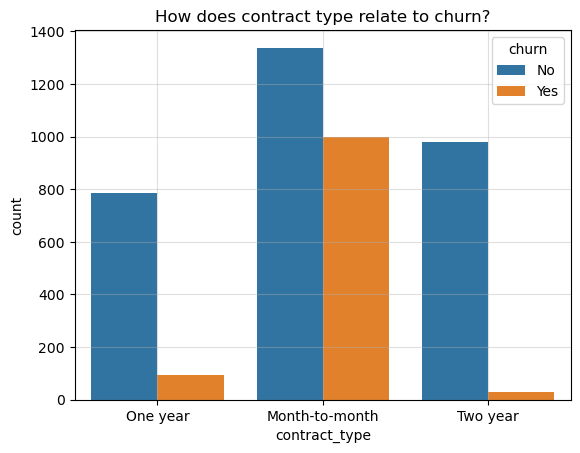

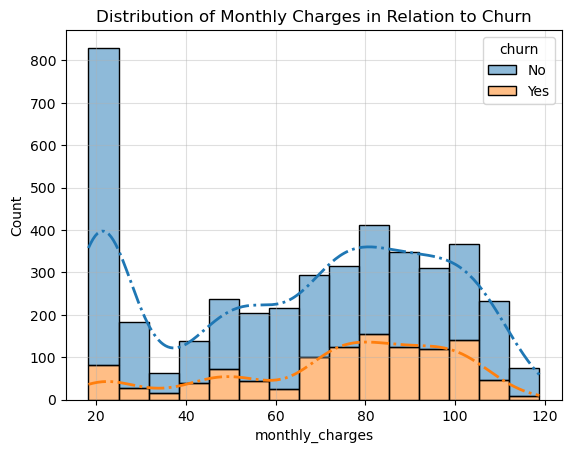

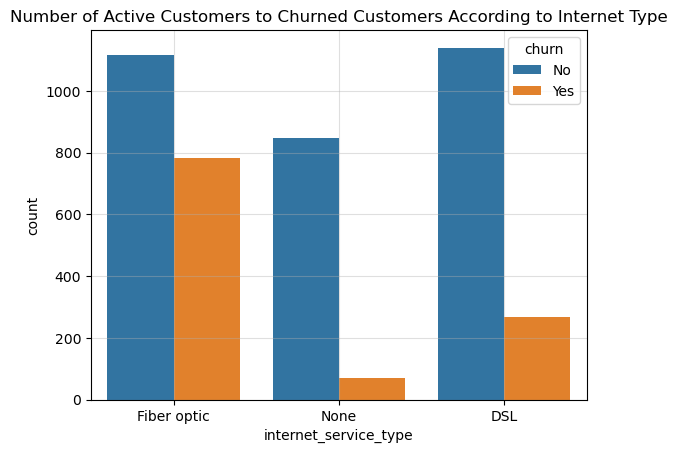

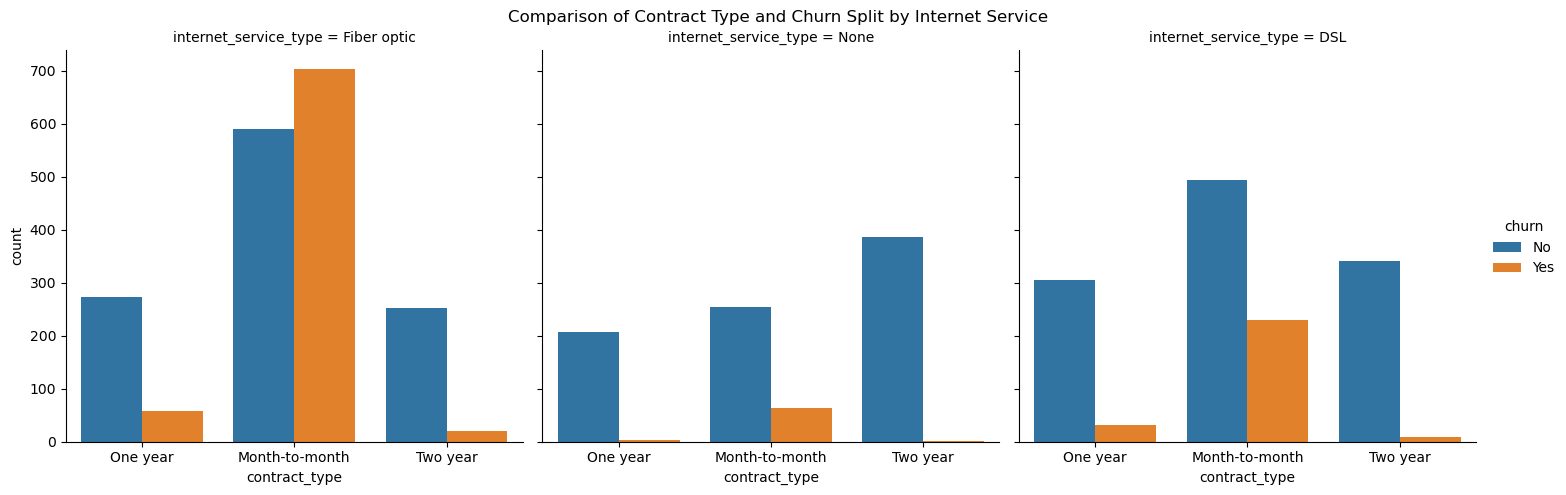

In [5]:
# explore data
explore.telco_plots(train)

In [6]:
# pre-process data for models
X_set,y_set = model.Xy_sets(tvt_set,'churn')
acquire.df_info(X_set[0])

,nunique,dtypes,isnull,5195-KPUNQ
tenure_months,73,int64,0,53.00
monthly_charges,1374,float64,0,96.75
total_charges,4006,float64,0,5206.55
gender_is_Male,2,float64,0,0.00
senior_citizen_is_Yes,2,float64,0,1.00
married_is_Yes,2,float64,0,0.00
children_is_Yes,2,float64,0,0.00
paperless_billing_is_Yes,2,float64,0,1.00
contract_type_is_One year,2,float64,0,1.00
contract_type_is_Two year,2,float64,0,0.00


In [7]:
# run modeling
dt_models = model.dt_modeling(X_set,y_set)
rf_models = model.rf_modeling(X_set,y_set)
knn_models = model.knn_modeling(X_set,y_set)
lr_models = model.lr_modeling(X_set,y_set)

In [8]:
# Filter models
dt_models = model.metrics_filter(dt_models,y_set[0])
rf_models = model.metrics_filter(rf_models,y_set[0])
knn_models = model.metrics_filter(knn_models,y_set[0])
lr_models = model.metrics_filter(lr_models,y_set[0])

In [9]:
# Select final best models
finals = model.final_models([dt_models,rf_models,knn_models,lr_models])
finals

,type,model,train_acc,validate_acc,hyperparameters,difference,average
2,RandomForest,"(DecisionTreeClassifier(max_depth=8, max_features='sqrt', random_state=843828734), Dec...",0.836450,0.803407,max_depth=8,0.033043,0.819928
3,RandomForest,"(DecisionTreeClassifier(max_depth=9, max_features='sqrt', random_state=843828734), Dec...",0.860355,0.806246,max_depth=9,0.054109,0.833300
8,LogisticRegression,"LogisticRegression(C=12, random_state=123)",0.803077,0.812633,C=12,-0.009556,0.807855


In [10]:
# Isolate the best model
best_model = finals.iloc[0,1]
best_model

RandomForestClassifier(max_depth=8, random_state=123)

In [11]:
# Run final test
best_model.score(X_set[2],y_set[2])

0.8055358410220014

In [12]:
# Generate CSV of overall model predictions
pd.DataFrame({
    'Customer_ID':X_set[2].index,
    # 'actual':y_set[2],
    'Probability of Churn':[prob[1] for prob in best_model.predict_proba(X_set[2])],
    'Prediction of Churn':np.where(best_model.predict(X_set[2]) == 'Yes', 1, 0)
}).to_csv('predictions.csv',index=False)